### For demonstration, I will consider datasets from sklearn for showcasing regression and classification

# Introduction

In [23]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init("/home/shounak/spark-3.1.2-bin-hadoop3.2")
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('demo').getOrCreate()
import pandas as pd
from sklearn.datasets import load_boston, load_iris
import time
import os
from pyspark.sql.functions import udf, countDistinct
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import evaluation
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import GBTClassifier, NaiveBayes, RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier

In [2]:
# Create scaler function
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

In [3]:
# Function to remove null and duplicate values
def rem_null_duplicates(dataframe):
    dataframe = dataframe.dropna()
    dataframe = dataframe.dropDuplicates()

In [4]:
def skdataset_to_sparkdataset(sklearn_dataset):
    load_sklearn_dataset = sklearn_dataset()
    pd_df = pd.DataFrame(data=load_sklearn_dataset["data"], columns=load_sklearn_dataset["feature_names"])
    pd_df["target"] = load_sklearn_dataset["target"]
    pd_df.to_csv("temp_df.csv", index=False)
    spark_df = spark.read.csv("temp_df.csv",inferSchema=True, header=True)
    return spark_df

# 1. Regression

In [8]:
regression_df = skdataset_to_sparkdataset(load_boston)
rem_null_duplicates(regression_df)
regression_df.show(2)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|    B|LSTAT|target|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|   15.3|396.9| 4.98|  24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421|78.9|4.9671|2.0|242.0|   17.8|396.9| 9.14|  21.6|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+-----+-----+------+
only showing top 2 rows



In [95]:
assembler_lin_reg = VectorAssembler(
    inputCols=[
        "CRIM",
        "ZN",
        "INDUS",
        "CHAS",
        "NOX",
        "RM",
        "AGE",
        "DIS",
        "RAD",
        "TAX",
        "PTRATIO",
        "B",
        "LSTAT",
    ],
    outputCol="raw_features",
)


regression_df = assembler_lin_reg.transform(regression_df)
regression_df = scaler.fit(regression_df).transform(regression_df)
regression_df = regression_df.select("features","target")

In [99]:
train_regression_df, test_regression_df = regression_df.randomSplit([0.8, 0.2])

In [101]:
linear_regression = LinearRegression(featuresCol='features',labelCol='target',)

In [102]:
lin_reg_model = linear_regression.fit(train_regression_df)

21/10/03 12:23:45 WARN Instrumentation: [82fb548f] regParam is zero, which might cause numerical instability and overfitting.
21/10/03 12:23:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/03 12:23:45 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/03 12:23:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
21/10/03 12:23:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [103]:
test_result = lin_reg_model.transform(test_regression_df)

In [104]:
test_result.show(3)

+--------------------+------+------------------+
|            features|target|        prediction|
+--------------------+------+------------------+
|[0.66629424479178...|  25.0| 28.81382707255313|
|[0.23370103573063...|  50.0| 36.25492397303093|
|[0.81643354932201...|  14.2|18.270560068934614|
+--------------------+------+------------------+
only showing top 3 rows



In [106]:
evaluator_lin_reg = evaluation.RegressionEvaluator(predictionCol="prediction", labelCol="target")

In [107]:
evaluation_lin_reg = evaluator_lin_reg.evaluate(test_result)

5.431707775801992


In [108]:
print("RSME for the Linear Regression model on test cases is ",evaluation_lin_reg)

RSME for the model on test cases is  5.431707775801992


# 2. Classification

In [9]:
classification_df = skdataset_to_sparkdataset(load_iris)
rem_null_duplicates(classification_df)
classification_df.show(2)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 2 rows



In [114]:
assembler_classification = VectorAssembler(inputCols=['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)',], outputCol="raw_features")

classification_df = assembler_classification.transform(classification_df)
classification_df = scaler.fit(classification_df).transform(classification_df)
classification_df = classification_df.select("features","target")

In [115]:
train_classification_df, test_classification_df = classification_df.randomSplit([0.8, 0.2])

In [ ]:
# GBTClassifier is limited to binary classification

In [116]:
nb = NaiveBayes(labelCol="target")
rf = RandomForestClassifier(labelCol="target") 
dc = DecisionTreeClassifier(labelCol="target")
mp = MultilayerPerceptronClassifier(labelCol="target", layers= [4,5,4,3])

In [118]:
nb_model = nb.fit(train_classification_df)
rf_model = rf.fit(train_classification_df)
dc_model = dc.fit(train_classification_df)
mp_model = mp.fit(train_classification_df)

In [119]:
nb_test_result = nb_model.transform(test_classification_df)
rf_test_result = rf_model.transform(test_classification_df)
dc_test_result = dc_model.transform(test_classification_df)
mp_test_result = mp_model.transform(test_classification_df)

In [121]:
evaluator_classification = evaluation.MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="target", metricName="accuracy"
)

In [122]:
print("Naive-Bayes Classifier accuracy: ", evaluator_classification.evaluate(nb_test_result))
print()
print("Random Forest Classifier accuracy: ", evaluator_classification.evaluate(rf_test_result))
print()
print("Decision Tree Classifier accuracy: ", evaluator_classification.evaluate(dc_test_result))
print()
print("Maltilayer Preceptron Classifier accuracy: ", evaluator_classification.evaluate(mp_test_result))

Naive-Bayes Classifier accuracy:  1.0

Random Forest Classifier accuracy:  0.9142857142857143

Decision Tree Classifier accuracy:  0.9142857142857143

Maltilayer Preceptron Classifier accuracy:  0.9428571428571428


21/10/03 14:11:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1966105 ms exceeds timeout 120000 ms
21/10/03 14:11:51 WARN SparkContext: Killing executors is not supported by current scheduler.


# 3. Clustering

In [5]:
from pyspark.ml.clustering import KMeans

In [19]:
clustering_df = skdataset_to_sparkdataset(load_iris)
rem_null_duplicates(clustering_df)
clustering_df.show(2)

+-----------------+----------------+-----------------+----------------+------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|target|
+-----------------+----------------+-----------------+----------------+------+
|              5.1|             3.5|              1.4|             0.2|     0|
|              4.9|             3.0|              1.4|             0.2|     0|
+-----------------+----------------+-----------------+----------------+------+
only showing top 2 rows



In [20]:
assembler_clustering = VectorAssembler(inputCols=['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)',], outputCol="raw_features")

In [21]:
clustering_df = assembler_clustering.transform(clustering_df)
clustering_df = scaler.fit(clustering_df).transform(clustering_df)
clustering_df = clustering_df.select("features","target")

In [22]:
clustering_df.show(2)

+--------------------+------+
|            features|target|
+--------------------+------+
|[6.15892840883878...|     0|
|[5.9174018045706,...|     0|
+--------------------+------+
only showing top 2 rows



In [35]:
model_cost_list = []
for i in range(2,7):
    km = KMeans(k=i)
    km_model = km.fit(clustering_df)
    model_cost_list.append(km_model.summary.trainingCost)

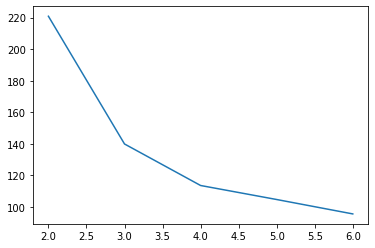

In [37]:
import matplotlib.pyplot as plt
plt.plot(list(range(2,7)), model_cost_list)

In [ ]:
# from above graph, it appears that elbow point is at "3". So we consider 3 optimal clusters

In [39]:
km = KMeans(k=3)
km_model = km.fit(clustering_df)
clustering_result_df = km_model.transform(clustering_df)

In [40]:
clustering_result_df.show(2)

+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[6.15892840883878...|     0|         1|
|[5.9174018045706,...|     0|         1|
+--------------------+------+----------+
only showing top 2 rows



In [41]:
clustering_result_df.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   49|
|         2|   46|
|         0|   55|
+----------+-----+



In [28]:
clustering_df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1|   50|
|     2|   50|
|     0|   50|
+------+-----+



From above, we see that KMeans has clustered the observations in 3 clusters. The count appears to be very close to the actual ones

# 4. Recommendation System

In [ ]:
# Currently, Collaborative Filtering is supported

In [63]:
from pyspark.ml.recommendation import ALS

In [64]:
# Dataset Location: https://www.kaggle.com/zygmunt/goodbooks-10k/version/5

recommendation_df = spark.read.csv("Spark_for_Machine_Learning/Recommender_Systems/ratings.csv", inferSchema=True, header=True)
recommendation_df.show(2)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
+-------+-------+------+
only showing top 2 rows



In [65]:
recommendation_df.count()

981756

In [66]:
train_recommendation_df, test_recommendation_df = recommendation_df.randomSplit([0.8, 0.2])

In [67]:
als = ALS(userCol='user_id',
    itemCol='book_id',
    ratingCol='rating',)

In [68]:
als_model = als.fit(train_recommendation_df)
result_train_df = als_model.transform(train_recommendation_df)

In [69]:
# Let us evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
regression_evaluator = RegressionEvaluator(predictionCol='prediction',labelCol='rating',)

In [70]:
recommendation_evaluator = regression_evaluator.evaluate(result_train_df)

In [71]:
print("RSME for the Recommendation System model on train cases is ",recommendation_evaluator)

RSME for the Recommendation System model on train cases is  0.5926992939442814


In [72]:
# Let us recommend products for 2 users as sample from test_recommendation_df
test_recommendation_df.show(2)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|   1169|     4|
|      1|  10335|     4|
+-------+-------+------+
only showing top 2 rows



In [79]:
recommendation_test_users = set()
i = 0
while len(recommendation_test_users) < 2:    # because we are testing on 2 sample users
    recommendation_test_users.add(test_recommendation_df.select("user_id").collect()[i][0])
    i += 1

In [83]:
recommendation_test_users = list(recommendation_test_users)

In [85]:
for user in recommendation_test_users:
    sample_case = test_recommendation_df[test_recommendation_df["user_id"] == user]
    result_sample_cases = als_model.transform(sample_case)
    result_sample_cases.show()

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|   3904|   1169|     3| 3.5186934|
|      1|   1169|     4| 3.8504627|
|    117|   1169|     3|  3.962414|
|    658|   1169|     4| 3.5735686|
|   9661|   1169|     4|  3.864401|
+-------+-------+------+----------+



+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|  10335|     4| 3.9550076|
|   6600|  10335|     3|  3.816544|
|   4584|  10335|     3| 3.7966855|
+-------+-------+------+----------+



# Natural Language Processing

In [1]:
import findspark
findspark.init("/home/shounak/spark-3.1.2-bin-hadoop3.2")
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("demo").getOrCreate()

21/10/14 07:37:57 WARN Utils: Your hostname, shounak-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
21/10/14 07:37:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/10/14 07:37:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


For Natural Language Processing, we will be using dataset of SMS texts which are classified into spam or ham.
We will train the model to classify the text.

In [2]:
nlp_data = spark.read.csv("Spark_for_Machine_Learning/Natural_Language_Processing/smsspamcollection/SMSSpamCollection", inferSchema=True, sep="\t")

In [3]:
nlp_data.show(5)

+----+--------------------+
| _c0|                 _c1|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
+----+--------------------+
only showing top 5 rows



In [4]:
nlp_data = nlp_data.withColumnRenamed("_c0","text_label")
nlp_data = nlp_data.withColumnRenamed("_c1","text")

In [5]:
nlp_data.show(2)

+----------+--------------------+
|text_label|                text|
+----------+--------------------+
|       ham|Go until jurong p...|
|       ham|Ok lar... Joking ...|
+----------+--------------------+
only showing top 2 rows



In [6]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline

In [7]:
regex_state = RegexTokenizer(inputCol="text",outputCol="tokenized_text")
stopword_removed_state = StopWordsRemover(inputCol="tokenized_text",outputCol="text_wo_stopwords")
hashTF_state = HashingTF(inputCol="text_wo_stopwords",outputCol="hashed_tf")
idf_state = IDF(inputCol="hashed_tf",outputCol="features")
string_labelling = StringIndexer(inputCol="text_label",outputCol="label")

pipeline_route = Pipeline(stages=[regex_state,
stopword_removed_state,
hashTF_state,
idf_state,])

In [8]:
nlp_data = pipeline_route.fit(nlp_data).transform(nlp_data)
nlp_data = string_labelling.fit(nlp_data).transform(nlp_data)

In [9]:
nlp_data = nlp_data.select(["features", "label"])

In [10]:
train_nlp_data, test_nlp_data = nlp_data.randomSplit([0.8, 0.2])

In [11]:
from pyspark.ml.classification import NaiveBayes

In [12]:
nbc = NaiveBayes(featuresCol='features', labelCol='label')

In [13]:
nbc_model = nbc.fit(train_nlp_data)

21/10/14 07:38:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
21/10/14 07:38:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [14]:
train_nlp_data_result = nbc_model.transform(train_nlp_data)
test_nlp_data_result = nbc_model.transform(test_nlp_data)

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction',labelCol='label', metricName="accuracy")

In [17]:
train_eval_score = evaluator.evaluate(train_nlp_data_result)
test_eval_score = evaluator.evaluate(test_nlp_data_result)
print("Train accuracy: ",train_eval_score)
print("Test accuracy: ",test_eval_score)

21/10/14 07:38:27 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
21/10/14 07:38:30 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


Train accuracy:  0.9977653631284916
Test accuracy:  0.9572338489535942


In [33]:
def show_category(text):
    sample_df_2 = spark.createDataFrame([{"text":sample_text}])
    sample_df_2 = pipeline_route.fit(sample_df_2).transform(sample_df_2)
    predicted_score = nbc_model.transform(sample_df_2).select(["text", "prediction"]).collect()[0]["prediction"]
    if predicted_score == 0:
        return "spam"
    else:
        return "ham"

In [35]:
# for demonstration, 
# we will pass random text samples from our dataframe without the label and see the prediction

spam_text_1 = "England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/ú1.20 POBOXox36504W45WQ 16+"
spam_text_2 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

ham_text_1 = "I HAVE A DATE ON SUNDAY WITH WILL!!"
ham_text_2 = "Are you this much buzy"

In [39]:
print("Model prediction for spam_text_1 is ", show_category(spam_text_1))
print("Model prediction for spam_text_2 is ", show_category(spam_text_2))
print("Model prediction for ham_text_1 is ", show_category(ham_text_1))
print("Model prediction for ham_text_2 is ", show_category(ham_text_2))

21/10/14 07:49:18 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for spam_text_1 is  spam


21/10/14 07:49:20 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for spam_text_2 is  spam


21/10/14 07:49:21 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


Model prediction for ham_text_1 is  spam
Model prediction for ham_text_2 is  spam


21/10/14 07:49:22 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
